# <font color = purple> 2023 Synopsys ARC AIoT Design Contest - Analog Gauge Calibration </font>

In [65]:
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
from PIL import Image

In [66]:
IMAGE_DIR = "./train_img"
LABEL_DIR = "./train_label/label.csv"
DEG_UNIT = 4

In [67]:
img_files = sorted(glob.glob(IMAGE_DIR + "/*"), key=os.path.getmtime) # Sort by time
lab_df = pd.read_csv(LABEL_DIR)['degree'].to_numpy()

In [68]:
img = cv2.imread(img_files[0])
height, width = img.shape[:2]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

In [69]:
def avg_circles(circles, b):
    avg_x = 0
    avg_y = 0
    avg_r = 0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    
    return avg_x, avg_y, avg_r

In [70]:
def gauge_calibration(img_path, separation=1):
    img = cv2.imread(img_path)
    height, width = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    
    # Detect circles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), 100, 50, int(height*0.35), int(height*0.48))
    a, b, c = circles.shape
    x, y, r = avg_circles(circles, b)

    # Draw center and circle
    cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)  # draw circle
    cv2.circle(img, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)  # draw center of circle

    interval = int(360 /separation)
    p1 = np.zeros((interval,2))  #set empty arrays
    p2 = np.zeros((interval,2))
    p_text = np.zeros((interval,2))
    for i in range(0,interval):
        for j in range(0,2):
            if (j%2==0):
                p1[i][j] = x + 0.9 * r * np.cos(separation * i * 3.14 / 180) #point for lines
            else:
                p1[i][j] = y + 0.9 * r * np.sin(separation * i * 3.14 / 180)
    text_offset_x = 10
    text_offset_y = 5
    for i in range(0, interval):
        for j in range(0, 2):
            if (j % 2 == 0):
                p2[i][j] = x + r * np.cos(separation * i * 3.14 / 180)
                p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+9) * 3.14 / 180) #point for text labels, i+9 rotates the labels by 90 degrees
            else:
                p2[i][j] = y + r * np.sin(separation * i * 3.14 / 180)
                p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+9) * 3.14 / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

    # Add the lines and labels to the image
    for i in range(0,interval):
        cv2.line(img, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
        # cv2.putText(img, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

    img = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))  


    return img

Text(0.5, 0.98, 'Analog Gauge Calibration - Scale Unit: 4')

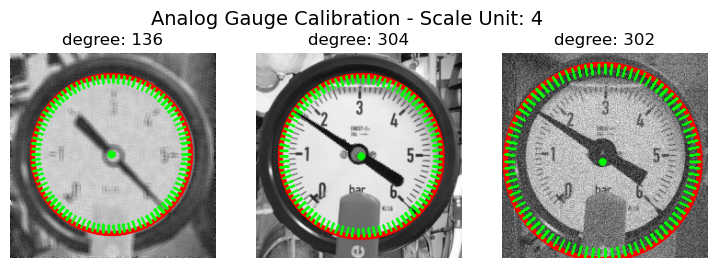

In [71]:
cnt = random.randint(0, len(img_files)/2)
fig = plt.figure(figsize=(9,3))

for i in range(3):  
    ax = fig.add_subplot(1, 3, i+1)
    
    flag = True
    while(flag):
        try:
            img_path = img_files[cnt]
            calibrate = gauge_calibration(img_path, separation=DEG_UNIT)
            calibrate = Image.fromarray(np.uint8(calibrate))
            calibrate = calibrate.convert('RGBA')
            degree = np.squeeze(lab_df[cnt])
            break
            
        except:
            sucess = True
            cnt += 1
            
        

    ax.imshow(calibrate)
    


    ax.set_title('degree: {y}'.format(y=degree))
    plt.axis('off')
    cnt += 1

fig.suptitle("Analog Gauge Calibration - Scale Unit: " + str(DEG_UNIT) , fontsize=14)

In [ ]:
# https://github.com/intel-iot-devkit/python-cv-samples/blob/master/examples/analog-gauge-reader/analog_gauge_reader.py